We will use the implementation of Holt-Winters Exponential Smoothing provided by the Statsmodels library. This model has hyperparameters that control the nature of the exponential performed for the series, trend, and seasonality, specifically:
- smoothing level (alpha): the smoothing coefficient for the level.  
- smoothing slope (beta): the smoothing coefficient for the trend.  
- smoothing seasonal (gamma): the smoothing coefficient for the seasonal component.  
- damping slope (phi): the coefficient for the damped trend.

There are other hyperparameters that the model will not automatically tune that you may want to specify; they are:
- trend: The type of trend component, as either add for additive or mul for multiplicative. Modeling the trend can be disabled by setting it to None.
- damped: Whether or not the trend component should be damped, either True or False.
- seasonal: The type of seasonal component, as either add for additive or mul for multiplicative. Modeling the seasonal component can be disabled by setting it to None.
- seasonal periods: The number of time steps in a seasonal period, e.g. 12 for 12 months in a yearly seasonal structure.
- use boxcox: Whether or not to perform a power transform of the series (True/False) or specify the lambda for the transform.

## Experiment ExponentialSmoothing

In [ ]:
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
#
from simple_forecast_framework import measure_rmse, train_test_split

In [ ]:
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t, d, s, p, b, r]
                            models.append(cfg)
    return models

In [ ]:
cfg_list = exp_smoothing_configs()

### Source Data

In [ ]:
data = np.arange(10, 110, 10)
print(data)
n_test = 4
#
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv'
df = pd.read_csv(url, header=0, index_col=0)
data = df.values[:,0]
n_test = 165

In [ ]:
# grid search
# scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
# result = walk_forward_validation(data, n_test, cfg)
# return (key, result)

In [ ]:
for cfg in cfg_list:
    # walk_forward_validation(data, n_test, cfg)
    predictions = list()
    train, test = train_test_split(data, n_test)
    print(train)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    first_i_for_each_cfg = True
    cfg_viable = True
    for i in range(len(test)):
        # fit model and make forecast for history
        # yhat = exp_smoothing_forecast(history, cfg)
        t,d,s,p,b,r = cfg
        history_np = np.array(history)
        # print('t = {} d = {} s = {} p = {}'.format(t, d, s, p))
        try:
            model = ExponentialSmoothing(history_np, trend=t, damped=d, seasonal=s, seasonal_periods=p)
            # fit model
            model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
            # make one step forecast
            yhat = model_fit.predict(len(history_np), len(history_np))
            print('model_fit len {} yhat {}'.format(len(history_np), yhat))
            if first_i_for_each_cfg:
                print('OK {} yhat[0] {}'.format(cfg, yhat))
                first_i_for_each_cfg = False
        except AttributeError:
            print('AttributeError {}'.format(cfg))
            cfg_viable = False
            break
        except ValueError:
            print('ValueError {}'.format(cfg))
            cfg_viable = False
            break
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop 
        history.append(test[i])
    # estimate prediction error 
    if cfg_viable:
        try:
            error = measure_rmse(test, predictions)
            print('cfg {} Error {}'.format(cfg, error))
        except ValueError:
            error = None

In [ ]:
data = np.arange(10, 110, 10)
print(data)
n_test = 4

## Test developed module under Import

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
from ETS_forecast_framework import exp_smoothing_configs, grid_search

cfg_list = exp_smoothing_configs()

In [ ]:
data = np.arange(10, 110, 10)
print(data)
n_test = 4
# grid search
%time scores = grid_search(data, cfg_list, n_test, parallel=True)

In [ ]:
# list top 3 configs 
for cfg, error in scores[:3]:
    print(cfg, error)

In [ ]:
df = pd.DataFrame(data=scores, columns=['cfg', 'error'])
print(df[df['cfg']=='[None, False, None, None, True, True]'])
print(df[df['cfg']=='[None, False, None, None, True, False]'])
print(df[df['cfg']=='[None, False, None, None, False, True]'])
print(df[df['cfg']=='[None, False, None, None, False, False]'])

## 12.3 Case Study 1: No Trend or Seasonality

The dataset has one year, or 365 observations. We will use the first 200 for training and the remaining 165 as the test set. The complete example grid searching the daily female univariate time series forecasting problem is listed below

In [2]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv'

In [3]:
df = pd.read_csv(url, header=0, index_col=0)
print(df.info())
print(df.head(5))

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 1959-01-01 to 1959-12-31
Data columns (total 1 columns):
Births    365 non-null int64
dtypes: int64(1)
memory usage: 5.7+ KB
None
            Births
Date              
1959-01-01      35
1959-01-02      32
1959-01-03      30
1959-01-04      31
1959-01-05      44


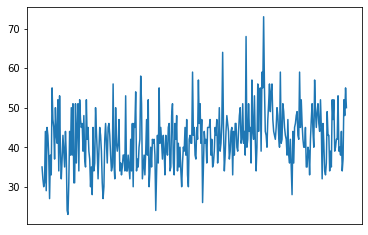

In [4]:
data = df.values
pyplot.plot(data)
pyplot.xticks([])
pyplot.show()

In [5]:
n_test = 165
# grid search
%time scores = grid_search(data[:,0], cfg_list, n_test, parallel=True)

cpu_count 8


/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:939: RuntimeWarning: invalid value encountered in double_scalars
  'initial_slope': b[0] / phi,
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:939: RuntimeWarning: invalid value encountered in double_scalars
  'initial_slope': b[0] / phi,
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/st

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packa

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packa

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packa

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: overflow encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/opt/miniconda3/envs/conda_env/lib/python3.7/site

[("['add', True, 'add', None, True, True]", None), ("['add', True, 'add', None, True, False]", None), ("['add', True, 'add', None, False, True]", None), ("['add', True, 'add', None, False, False]", None), ("['add', True, 'mul', None, True, True]", None), ("['add', True, 'mul', None, True, False]", None), ("['add', True, 'mul', None, False, True]", None), ("['add', True, 'mul', None, False, False]", None), ("['add', True, None, None, True, True]", None), ("['add', True, None, None, True, False]", None), ("['add', True, None, None, False, True]", None), ("['add', True, None, None, False, False]", None), ("['add', False, 'add', None, True, True]", None), ("['add', False, 'add', None, True, False]", None), ("['add', False, 'add', None, False, True]", None), ("['add', False, 'add', None, False, False]", None), ("['add', False, 'mul', None, True, True]", None), ("['add', False, 'mul', None, True, False]", None), ("['add', False, 'mul', None, False, True]", None), ("['add', False, 'mul', None

In [6]:
# list top 3 configs 
for cfg, error in scores[:3]:
    print(cfg, error)

['mul', False, None, None, True, True] 6.899874475211987
['mul', False, None, None, True, False] 6.92374999497313
['add', False, None, None, True, True] 7.073633035889047


[' mul' , False, None, None, True, True] 6.960703917145126

[' mul' , False, None, None, True, False] 6.984513598720297

[' add' , False, None, None, True, True] 7.081359856193836

We can see that the best result was an RMSE of about 6.96 births. A naive model achieved
an RMSE of 6.93 births, meaning that the best performing ETS model is not skillful on this problem. We can unpack the configuration of the best performing model as follows:
- Trend: Multiplicative 
- Damped: False 
- Seasonal: None 
- Seasonal Periods: None 
- Box-Cox Transform: True 
- Remove Bias: True

## 12.4 Case Study 2: Trend

In [7]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv'

In [8]:
df = pd.read_csv(url, header=0, index_col=0)
print(df.info())
print(df.head(5))

<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, 1-01 to 3-12
Data columns (total 1 columns):
Sales    36 non-null float64
dtypes: float64(1)
memory usage: 576.0+ bytes
None
       Sales
Month       
1-01   266.0
1-02   145.9
1-03   183.1
1-04   119.3
1-05   180.3


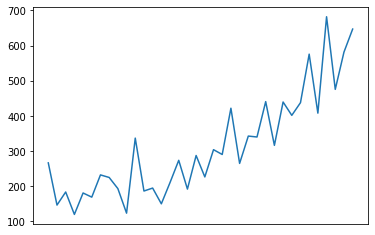

In [9]:
pyplot.plot(df)
pyplot.xticks([])
pyplot.draw()

The dataset has three years, or 36 observations. We will use the first 24 for training and the remaining 12 as the test set.

In [10]:
data = df.values
n_test = 12
%time scores = grid_search(data[:,0], cfg_list, n_test, parallel=True)

cpu_count 8


/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/scipy/stats/morestats.py:902: RuntimeWarning: divide by zero encountered in log
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/scipy/optimize/optimize.py:2315: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/scipy/optimize/optimize.py:1933: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/opt/miniconda3/envs/conda_en

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/scipy/optimize/optimize.py:2315: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/scipy/optimize/optimize.py:1933: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/scipy/optimize/optimize.py:1935: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packa

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packa

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/scipy/optimize/optimize.py:1936: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/stat

[("['add', True, 'add', None, True, True]", None), ("['add', True, 'add', None, True, False]", None), ("['add', True, 'add', None, False, True]", None), ("['add', True, 'add', None, False, False]", None), ("['add', True, 'mul', None, True, True]", None), ("['add', True, 'mul', None, True, False]", None), ("['add', True, 'mul', None, False, True]", None), ("['add', True, 'mul', None, False, False]", None), ("['add', True, None, None, True, True]", None), ("['add', True, None, None, True, False]", None), ("['add', True, None, None, False, True]", 97.91815887285195), ("['add', True, None, None, False, False]", 103.06878140205062), ("['add', False, 'add', None, True, True]", None), ("['add', False, 'add', None, True, False]", None), ("['add', False, 'add', None, False, True]", None), ("['add', False, 'add', None, False, False]", None), ("['add', False, 'mul', None, True, True]", None), ("['add', False, 'mul', None, True, False]", None), ("['add', False, 'mul', None, False, True]", None), (

In [11]:
print(len(scores))

10


In [12]:
for cfg, error in scores[:3]:
    print(cfg, error)

['mul', False, None, None, False, False] 83.7426984167569
['mul', False, None, None, False, True] 86.27283368490956
['add', True, None, None, False, True] 97.91815887285195


[' mul' , False, None, None, False, False] 83.74666940175238
[' mul' , False, None, None, False, True] 86.40648953786152
[' mul' , True, None, None, False, True] 95.33737598817238

We can see that the best result was an RMSE of about 83.74 sales. A naive model achieved
an RMSE of 95.69 sales on this dataset, meaning that the best performing ETS model is skillful on this problem. We can unpack the configuration of the best performing model as follows:
 Trend: Multiplicative 
 Damped: False 
 Seasonal: None 
 Seasonal Periods: None 
 Box-Cox Transform: False 
 Remove Bias: False

## 12.5 Case Study 3: Seasonality

In [13]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-mean-temp.csv'

In [18]:
df = pd.read_csv(url, header=0, index_col=0)
print(df.info())
print(df.tail(5))

<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 1920-01 to 1939-12
Data columns (total 1 columns):
Temperature    240 non-null float64
dtypes: float64(1)
memory usage: 3.8+ KB
None
         Temperature
Month               
1939-08         61.8
1939-09         58.2
1939-10         46.7
1939-11         46.6
1939-12         37.8


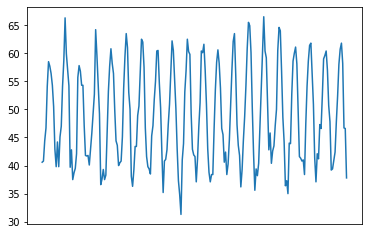

In [16]:
pyplot.plot(df)
pyplot.xticks([])
pyplot.show()

The dataset has 20 years, or 240 observations. We will trim the dataset to the last five years of data (60 observations) in order to speed up the model evaluation process and use the last year or 12 observations for the test set.

In [22]:
data = df[-60:].values
n_test = 12
cfg_list = exp_smoothing_configs(seasonal=[0,12])
%time scores = grid_search(data[:,0], cfg_list, n_test, parallel=True)

cpu_count 8


/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packa

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packa

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packa

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packa

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packa

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packa

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packa

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packa

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packa

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packa

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packa

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packa

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packa

[("['add', True, 'add', 0, True, True]", None), ("['add', True, 'add', 0, True, False]", None), ("['add', True, 'add', 0, False, True]", None), ("['add', True, 'add', 0, False, False]", None), ("['add', True, 'add', 12, True, True]", 1.6457126586157367), ("['add', True, 'add', 12, True, False]", 1.6377115453341355), ("['add', True, 'add', 12, False, True]", 1.568153508922937), ("['add', True, 'add', 12, False, False]", 1.5545873020659413), ("['add', True, 'mul', 0, True, True]", None), ("['add', True, 'mul', 0, True, False]", None), ("['add', True, 'mul', 0, False, True]", None), ("['add', True, 'mul', 0, False, False]", None), ("['add', True, 'mul', 12, True, True]", 1.662571108614943), ("['add', True, 'mul', 12, True, False]", 1.6592253076734873), ("['add', True, 'mul', 12, False, True]", 1.602852456679028), ("['add', True, 'mul', 12, False, False]", 1.6091784988390756), ("['add', True, None, 0, True, True]", 4.654909602637357), ("['add', True, None, 0, True, False]", 4.5974633562589

In [23]:
print(len(scores))

79


In [24]:
for cfg, error in scores[:3]:
    print(cfg, error)

['mul', False, 'mul', 12, False, False] 1.492902427370352
[None, False, 'mul', 12, False, True] 1.5015589821379238
[None, False, 'mul', 12, False, False] 1.5015596601788201


[None, False, ' add' , 12, False, False] 1.5015527325330889 
[None, False, ' add' , 12, False, True] 1.5015531225114707 
[None, False, ' mul' , 12, False, False] 1.501561363221282

## 12.6 Case Study 4: Trend and Seasonality

In [25]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'

In [26]:
df = pd.read_csv(url, header=0, index_col=0)
print(df.info())
print(df.head(5))

<class 'pandas.core.frame.DataFrame'>
Index: 108 entries, 1960-01 to 1968-12
Data columns (total 1 columns):
Sales    108 non-null int64
dtypes: int64(1)
memory usage: 1.7+ KB
None
         Sales
Month         
1960-01   6550
1960-02   8728
1960-03  12026
1960-04  14395
1960-05  14587


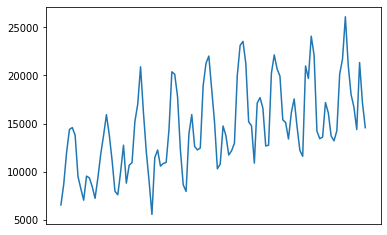

In [27]:
pyplot.plot(df)
pyplot.xticks([])
pyplot.show()

The dataset has 9 years, or 108 observations. We will use the last year or 12 observations as the test set. The period of the seasonal component could be six months or 12 months.

In [28]:
data = df.values
n_test = 12
cfg_list = exp_smoothing_configs(seasonal=[6,12])
%time scores = grid_search(data[:,0], cfg_list, n_test, parallel=True)

cpu_count 8


/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packa

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packa

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packa

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packa

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packa

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:873: RuntimeWarning: invalid value encountered in power
  b[:nobs] = dampen(b[:nobs], phi)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:863: RuntimeWarning: invalid value encountered in power
  (alphac * trended(lvls[i - 1], dampen(b[i - 1], phi)))
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:866: RuntimeWarning: invalid value encountered in power
  (betac * dampen(b[i - 1], phi))
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:867: RuntimeWarning: invalid value encountered in power
  s[i + m - 1] = y_gamma[i - 1] / trended(lvls[i - 1], dampen(b[i - 1], phi)) + \
/opt/miniconda3/env

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packa

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packa

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packa

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packa

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packa

[("['add', True, 'add', 6, True, True]", 2807.2030837416487), ("['add', True, 'add', 6, True, False]", 2805.494919464416), ("['add', True, 'add', 6, False, True]", 3240.432815614594), ("['add', True, 'add', 6, False, False]", 3226.3839394600964), ("['add', True, 'add', 12, True, True]", None), ("['add', True, 'add', 12, True, False]", None), ("['add', True, 'add', 12, False, True]", 1708.5636609639882), ("['add', True, 'add', 12, False, False]", 1698.5322465963152), ("['add', True, 'mul', 6, True, True]", 2949.991246652715), ("['add', True, 'mul', 6, True, False]", 2934.4171014280973), ("['add', True, 'mul', 6, False, True]", 3007.456147373017), ("['add', True, 'mul', 6, False, False]", 2991.227185322239), ("['add', True, 'mul', 12, True, True]", None), ("['add', True, 'mul', 12, True, False]", None), ("['add', True, 'mul', 12, False, True]", None), ("['add', True, 'mul', 12, False, False]", None), ("['add', True, None, 6, True, True]", 3935.6929155720472), ("['add', True, None, 6, Tru

In [29]:
print(len(scores))

102


In [30]:
for cfg, error in scores[:3]:
    print(cfg, error)

['mul', False, 'add', 12, False, True] 1594.9836617446458
['mul', False, 'add', 12, False, False] 1602.0722496145022
['add', True, 'add', 12, False, False] 1698.5322465963152


We can see that the best result was an RMSE of about 1,672 sales. A naive model achieved
an RMSE of 1841.15 sales on this problem, suggesting that the best performing ETS model is skillful. We can unpack the configuration of the best performing model as follows:
 Trend: Additive  Damped: False  Seasonal: Additive
 Seasonal Periods: 12  Box-Cox Transform: False  Remove Bias: True This is a little surprising as I would have guessed that a six-month seasonal model would be
the preferred approach.